#### initialize some parameters

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tck


# without smearing:
# smearing_str = 'no Smearing'
# momemta_weight_filepath = "weights10.csv"
# madminer_model_files = '/home/zbhatti/codebase/madminer/momemta/inputs/alice_wo_smearing/alice'
# madminer_x_test_filepath = '/home/zbhatti/codebase/madminer/momemta/inputs/x_test_wo_smearing.npy'


# with smearing:
# smearing_str = 'with Smearing'
# momemta_weight_filepath = "weights11.csv"
# madminer_model_files = '/home/zbhatti/codebase/madminer/momemta/inputs/alice_w_smearing/alice'
# madminer_x_test_filepath = '/home/zbhatti/codebase/madminer/momemta/inputs/x_test_w_smearing.npy'

# hpc:
smearing_str = 'with Smearing'
momemta_weight_filepath = "weights15.csv"
madminer_model_files = '/home/zbhatti/codebase/madminer/momemta/inputs/alice_hpc/alice'
madminer_x_test_filepath = '/home/zbhatti/codebase/madminer/momemta/inputs/x_test.npy'


#### Load momemta results

In [2]:


momemta_out = np.genfromtxt(momemta_weight_filepath, delimiter=",")

benchmarks = momemta_out[0,:-1]
n_benchmarks = benchmarks.shape[0]
momemta_weights = momemta_out[1:,:-1]
n_events = momemta_weights.shape[0]
expected_benchmark_idx = 12
top_width = 1.5
print 'expected benchmark: {}'.format(benchmarks[expected_benchmark_idx])
print benchmarks, benchmarks.shape

expected benchmark: 172.0
[160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.
 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185.] (26,)


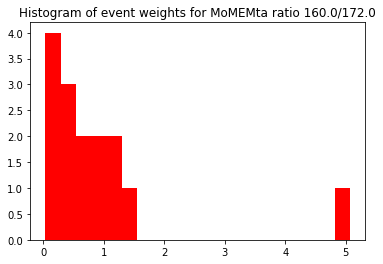

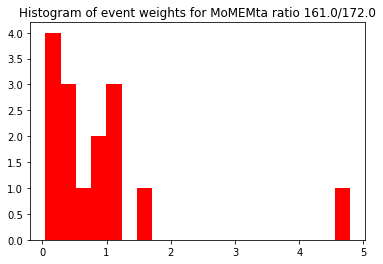

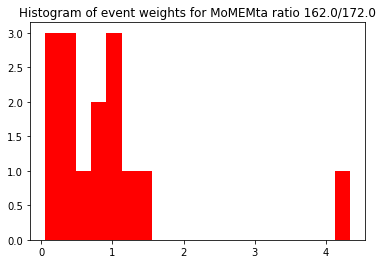

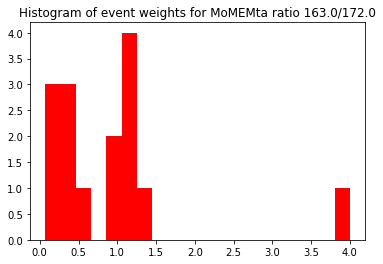

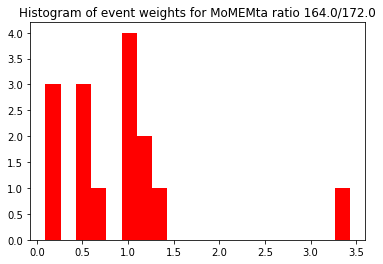

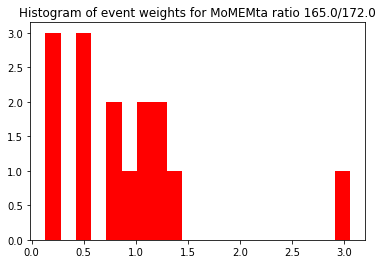

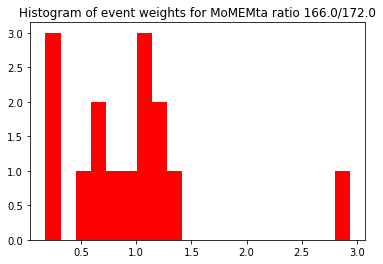

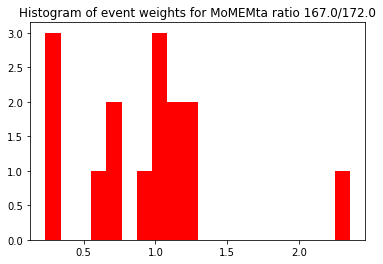

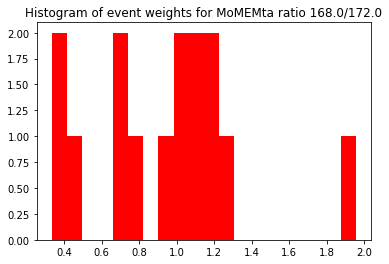

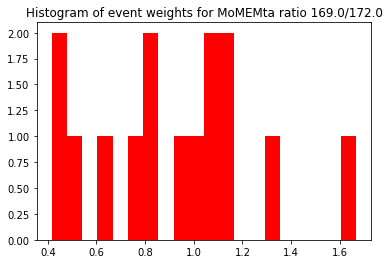

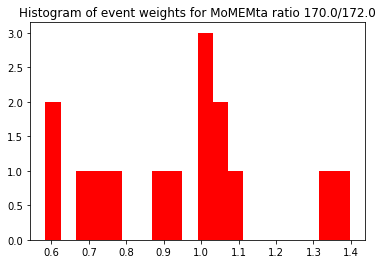

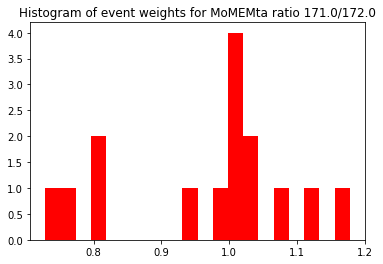

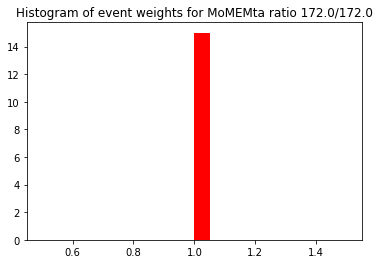

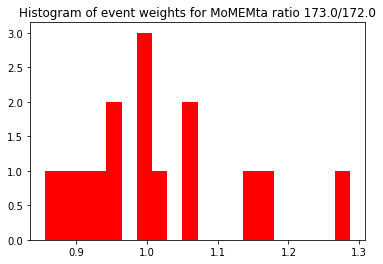

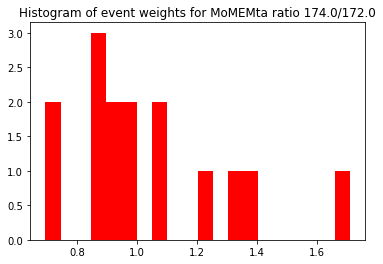

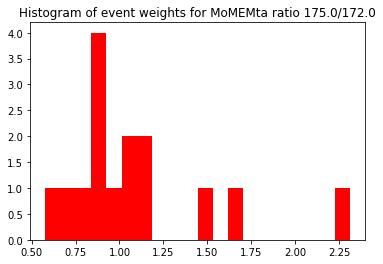

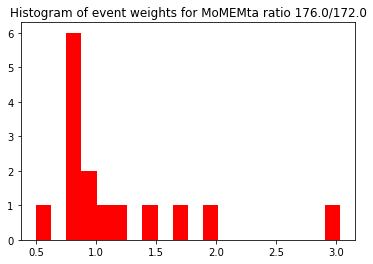

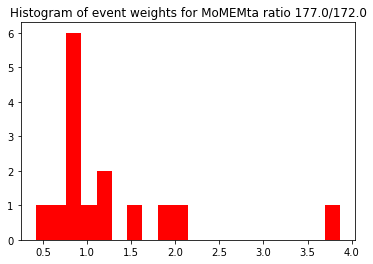

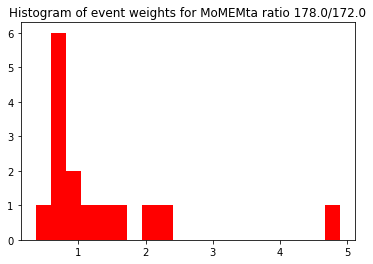

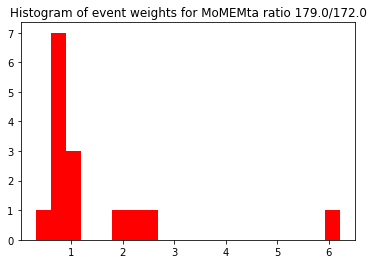

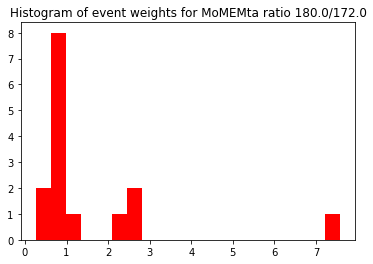

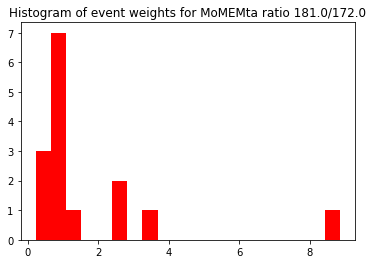

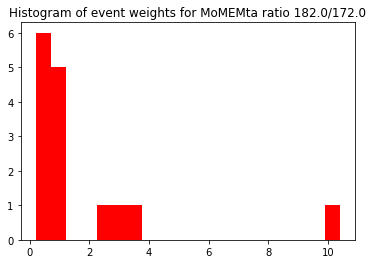

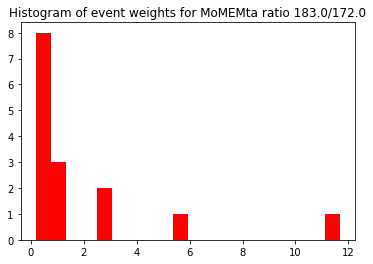

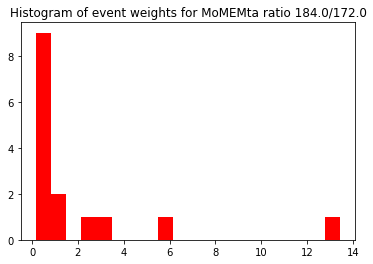

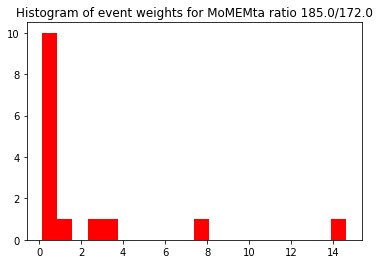

In [3]:
momemta_ratios = []
for event_weights in momemta_weights:
    momemta_ratios.append(event_weights/event_weights[expected_benchmark_idx])
momemta_ratios = np.array(momemta_ratios)

for idx, benchmark in enumerate(benchmarks):
    plt.hist(momemta_ratios[:,idx],bins=20, color='red')
    plt.title('Histogram of event weights for MoMEMta ratio {}/{}'.format(benchmarks[idx], benchmarks[expected_benchmark_idx]))
    plt.show()

In [4]:
momemta_log_sq_ratios = []
momemta_log_ratios = []
for ratio in momemta_ratios:
    momemta_log_ratios.append(np.log(ratio))
    momemta_log_sq_ratios.append(-2 * np.log(ratio))
    
momemta_log_ratios = np.array(momemta_log_ratios)
momemta_log_sq_ratios = np.array(momemta_log_sq_ratios)

print momemta_log_sq_ratios[0][0], momemta_log_sq_ratios[0][expected_benchmark_idx], momemta_log_sq_ratios[0][-1]

6.746087445975992 -0.0 -2.2426325418052024


In [5]:
momemta_sum_log_sq_ratios = np.mean(momemta_log_sq_ratios, axis=0)
print momemta_sum_log_sq_ratios

[ 1.62025887  1.42090754  1.25003934  1.06902471  0.8999222   0.81891529
  0.62904761  0.46736309  0.35365555  0.31157307  0.18250426  0.0806861
  0.         -0.02060623 -0.0293929  -0.08039112 -0.13907326 -0.14961917
 -0.17516888 -0.17772229 -0.14808678 -0.14101635 -0.14569614 -0.14855789
 -0.11271388 -0.06623119]


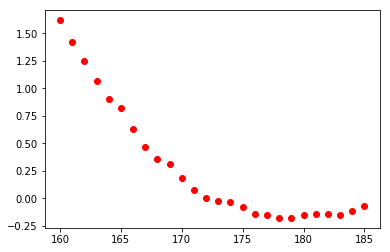

In [6]:
plt.plot(benchmarks, momemta_sum_log_sq_ratios, 'o', color='red');

#### Load madminer model and extract event-level ratios

In [7]:
from madminer.ml import ParameterizedRatioEstimator

In [8]:
forge = ParameterizedRatioEstimator(n_hidden=(100, 100))
forge.load(madminer_model_files)
theta0 = np.vstack( (np.linspace(benchmarks[0], benchmarks[-1], n_benchmarks), top_width*np.ones(n_benchmarks)) ).T
x = np.load(madminer_x_test_filepath)[:n_events,:]
log_ratios_T, _0 = forge.evaluate_log_likelihood_ratio(x=x, theta=theta0, test_all_combinations=True, run_on_gpu=False)
n_observables = x.shape[1]
print theta0.shape, x.shape, log_ratios_T.shape

(26, 2) (15, 23) (26, 15)


Text(0.5,1,'Madminer Log Likelihood Ratio on 15 Events')

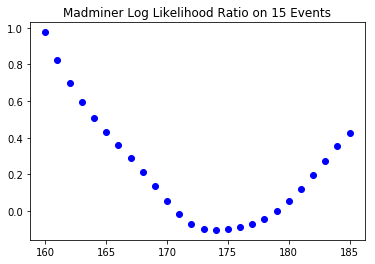

In [9]:
madminer_log_ratios = log_ratios_T.T
madminer_log_sq_ratios = -2*madminer_log_ratios
madminer_sum_log_sq_ratios = np.mean(-2*madminer_log_ratios, axis=0)
plt.plot(benchmarks, madminer_sum_log_sq_ratios, 'o', color='blue')
plt.title('Madminer Log Likelihood Ratio on {} Events'.format(n_events))

Text(0.5,1,'Madminer Log Likelihood Ratio on 100 Events')

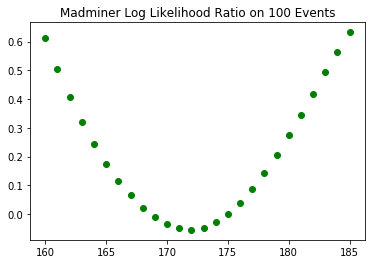

In [10]:
# Evaluate log likelihood on many events
n_many_events = 100
x_many = np.load(madminer_x_test_filepath)[:n_many_events,:]
log_ratios_T_many, _0 = forge.evaluate_log_likelihood_ratio(x=x_many, theta=theta0, test_all_combinations=True, run_on_gpu=False)
madminer_sum_log_sq_ratios_many = np.mean(-2*log_ratios_T_many.T, axis=0)
plt.plot(benchmarks, madminer_sum_log_sq_ratios_many, 'o', color='green')
plt.title('Madminer Log Likelihood Ratio on {} Events'.format(n_many_events))

# Comparing madminer with MoMEMta

### compare all events with all bechmarks

(15, 26)


/home/zbhatti/.conda/envs/mm_vs_mem/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


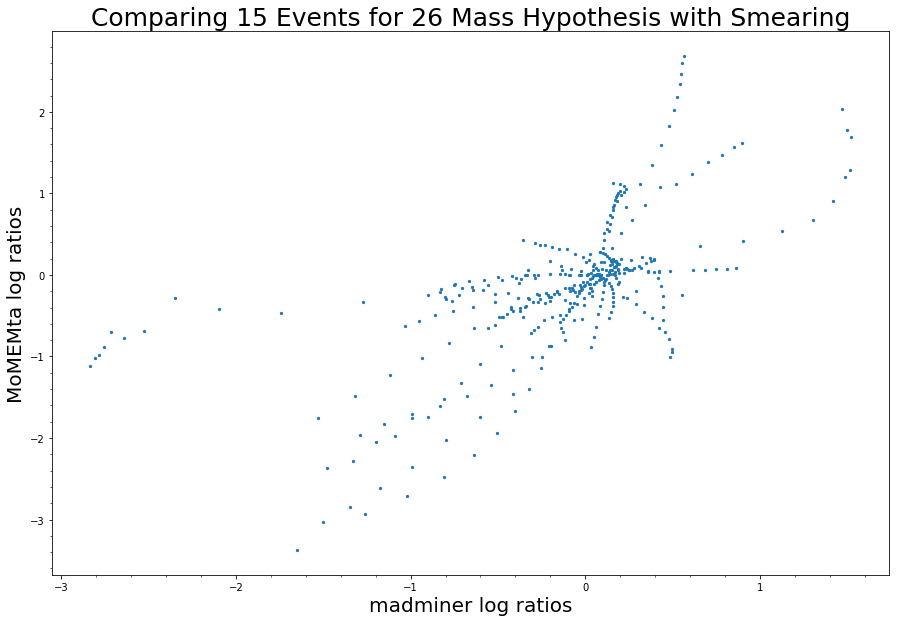

In [11]:
plt.figure(figsize=(15,10))
print(madminer_log_sq_ratios.shape)
plt.scatter(madminer_log_ratios, momemta_log_ratios, marker='o', s=5)
plt.xlabel('madminer log ratios', fontsize=20)
plt.ylabel('MoMEMta log ratios', fontsize=20)
plt.title('Comparing {} Events for {} Mass Hypothesis {}'.format(n_events, n_benchmarks, smearing_str), fontsize=25)
plt.axes().yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.axes().xaxis.set_minor_locator(tck.AutoMinorLocator())
plt.show()

### compare each event for all benchmarks

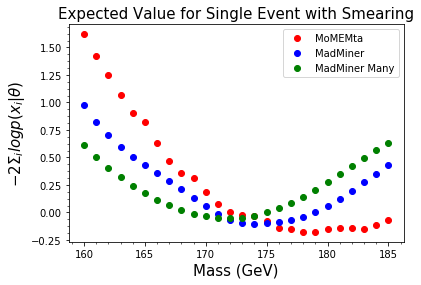

In [12]:
plt.plot(benchmarks, momemta_sum_log_sq_ratios, 'o', color='red', label='MoMEMta')
plt.plot(benchmarks, madminer_sum_log_sq_ratios, 'o', color='blue', label='MadMiner')
plt.plot(benchmarks, madminer_sum_log_sq_ratios_many, 'o', color='green', label='MadMiner Many')
plt.legend()
plt.xlabel('Mass (GeV)', fontsize=15)
# plt.ylabel(r'Sum of Log Squared Likelihood Ratios')
plt.ylabel(r'$-2\Sigma_i logp(x_i|\theta)$', fontsize=15)
plt.title('Expected Value for Single Event {}'.format(smearing_str), fontsize=15)
plt.axes().yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.axes().xaxis.set_minor_locator(tck.AutoMinorLocator())
plt.show()

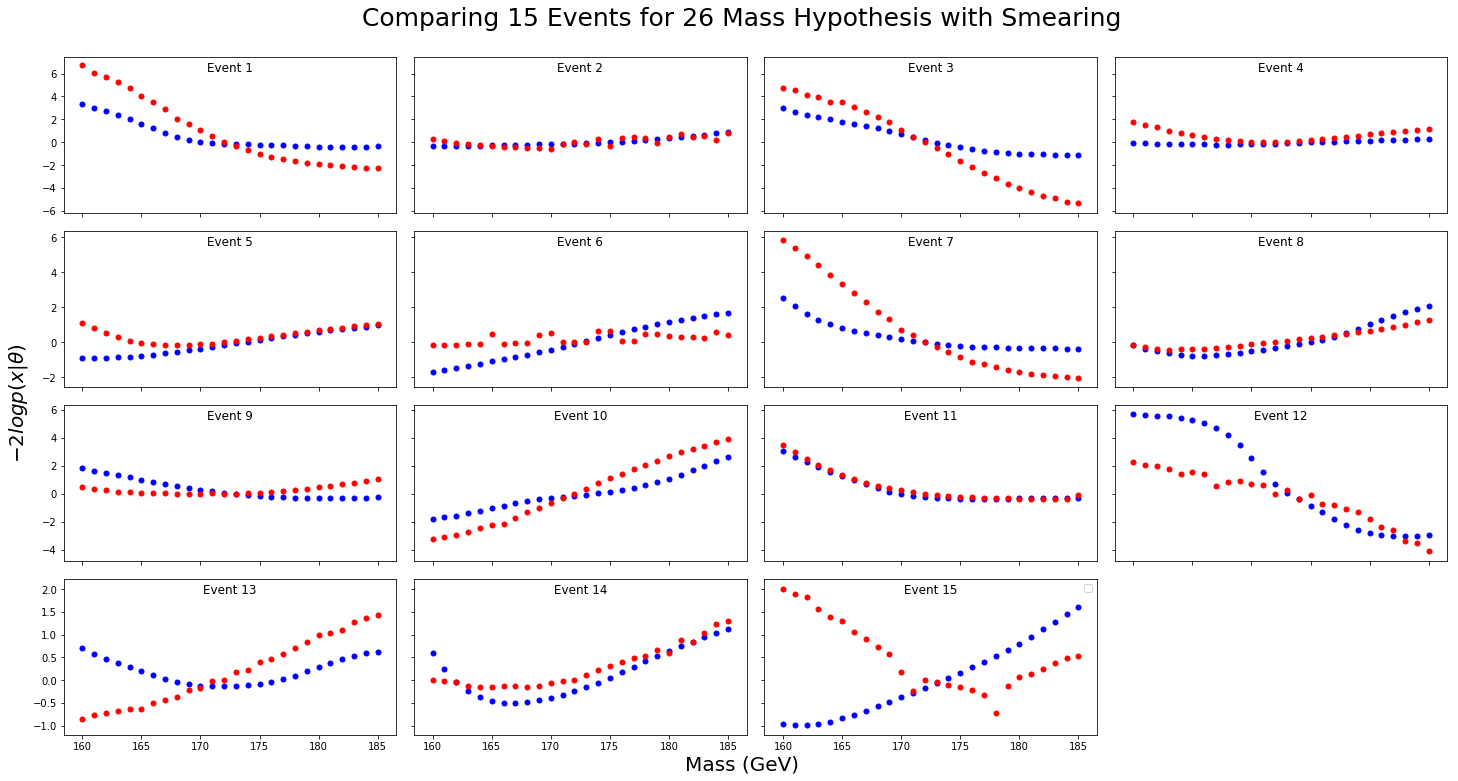

In [13]:
m, n = 4, 4
fig, ax = plt.subplots(m, n, sharex='col', sharey='row')
fig.set_size_inches(20,10)
for i in range(0, n_events):
    x, y = i // m, i % n 
    ax[x][y].scatter(benchmarks, madminer_log_sq_ratios[i], marker='o', color='blue', s=25)
    ax[x][y].scatter(benchmarks, momemta_log_sq_ratios[i] - momemta_log_sq_ratios[i, expected_benchmark_idx], marker='o', color='red', s=25)
    ax[x][y].set_title('Event {}'.format(i + 1),pad=-15)

fig.delaxes(ax[-1][-1])
fig.text(0.5, -0.01, 'Mass (GeV)', ha='center', fontsize=20)
fig.text(-0.01, 0.5, r'$-2logp(x|\theta)$', va='center', rotation='vertical', fontsize=20)
fig.text(0.5, 1.05, 'Comparing {} Events for {} Mass Hypothesis {}'.format(n_events, n_benchmarks, smearing_str), ha='center', va='top', fontsize=25)
plt.legend()
plt.tight_layout()
plt.show()

### compare all events for each bechmark

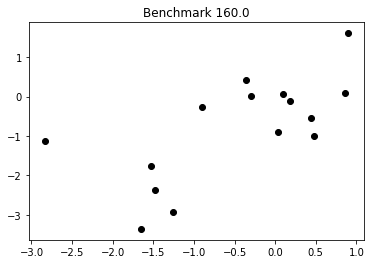

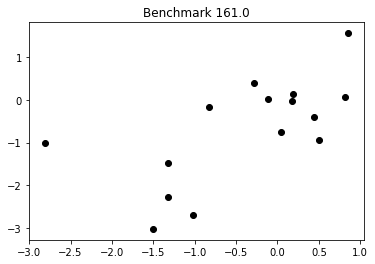

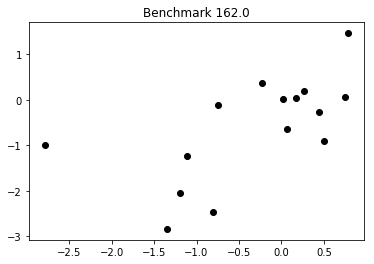

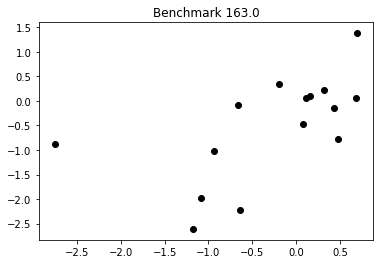

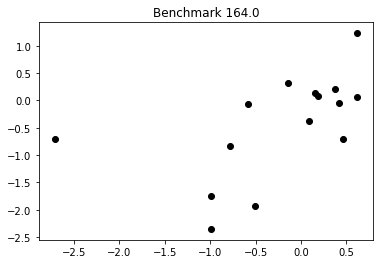

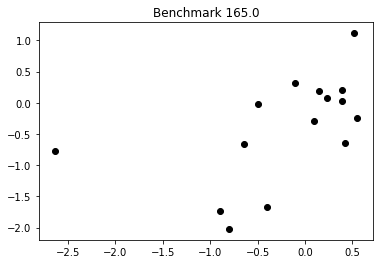

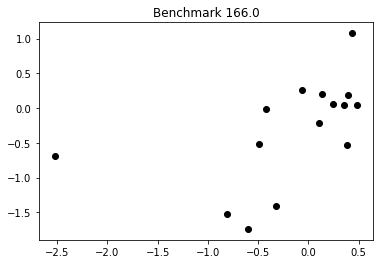

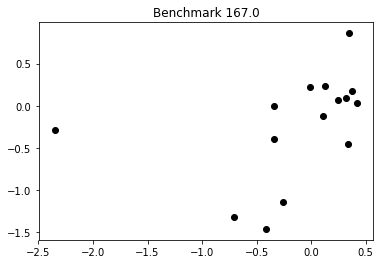

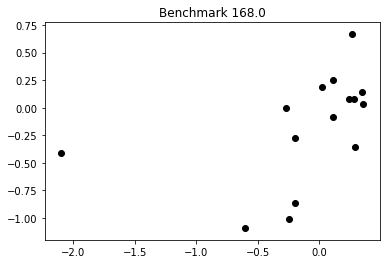

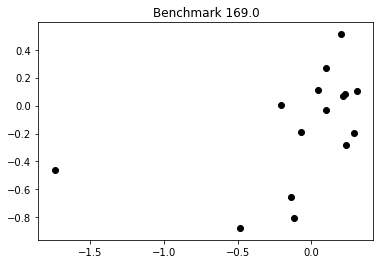

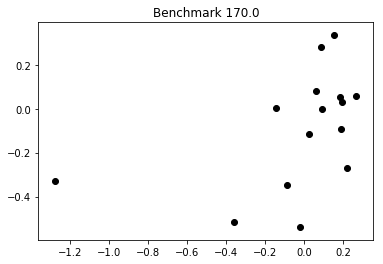

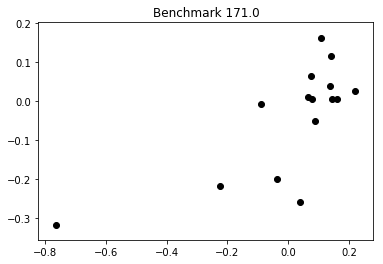

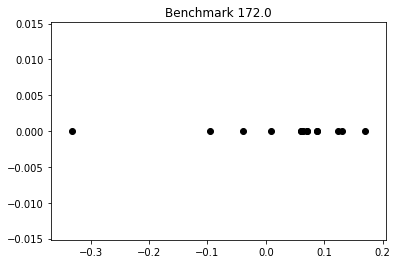

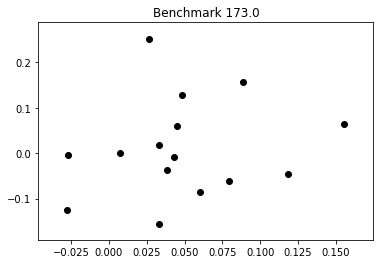

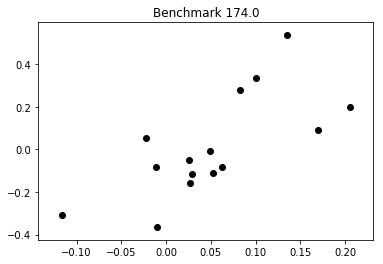

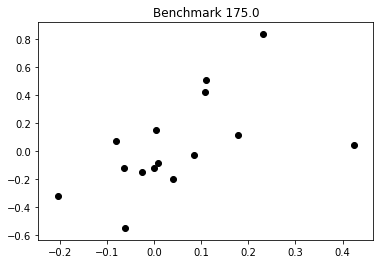

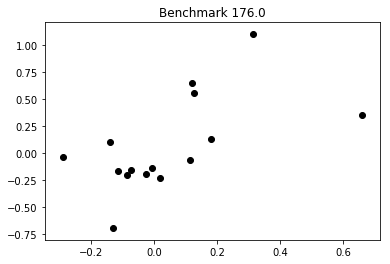

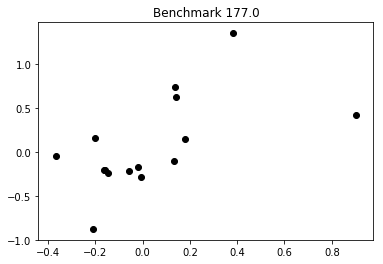

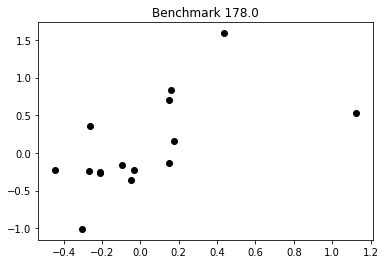

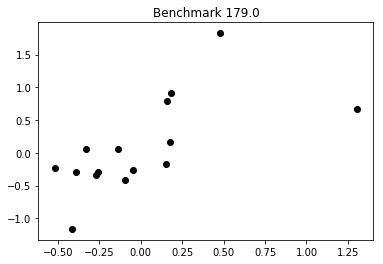

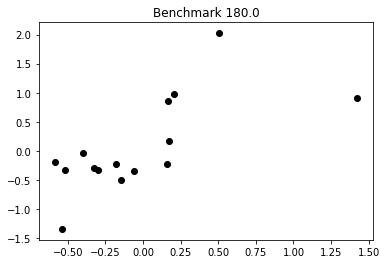

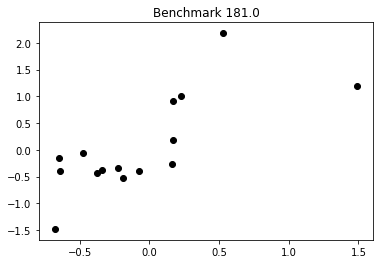

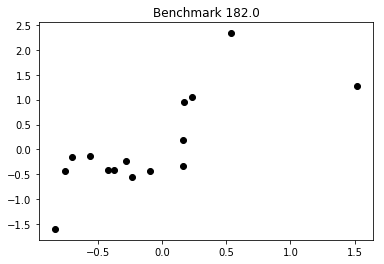

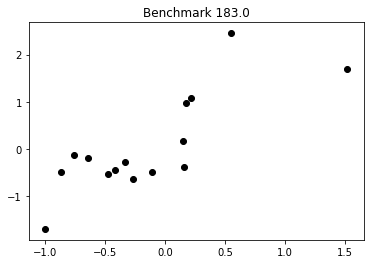

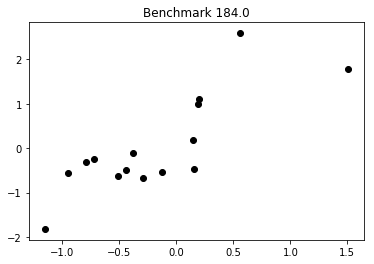

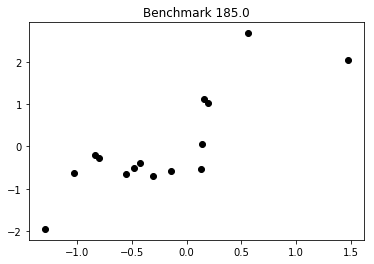

In [14]:
for i in range(0,madminer_log_ratios.shape[1]):
    plt.scatter(madminer_log_ratios[:,i], momemta_log_ratios[:,i] - momemta_log_ratios[:,expected_benchmark_idx], marker='o', color='black');
    plt.title('Benchmark {}'.format(benchmarks[i]))
    plt.show()

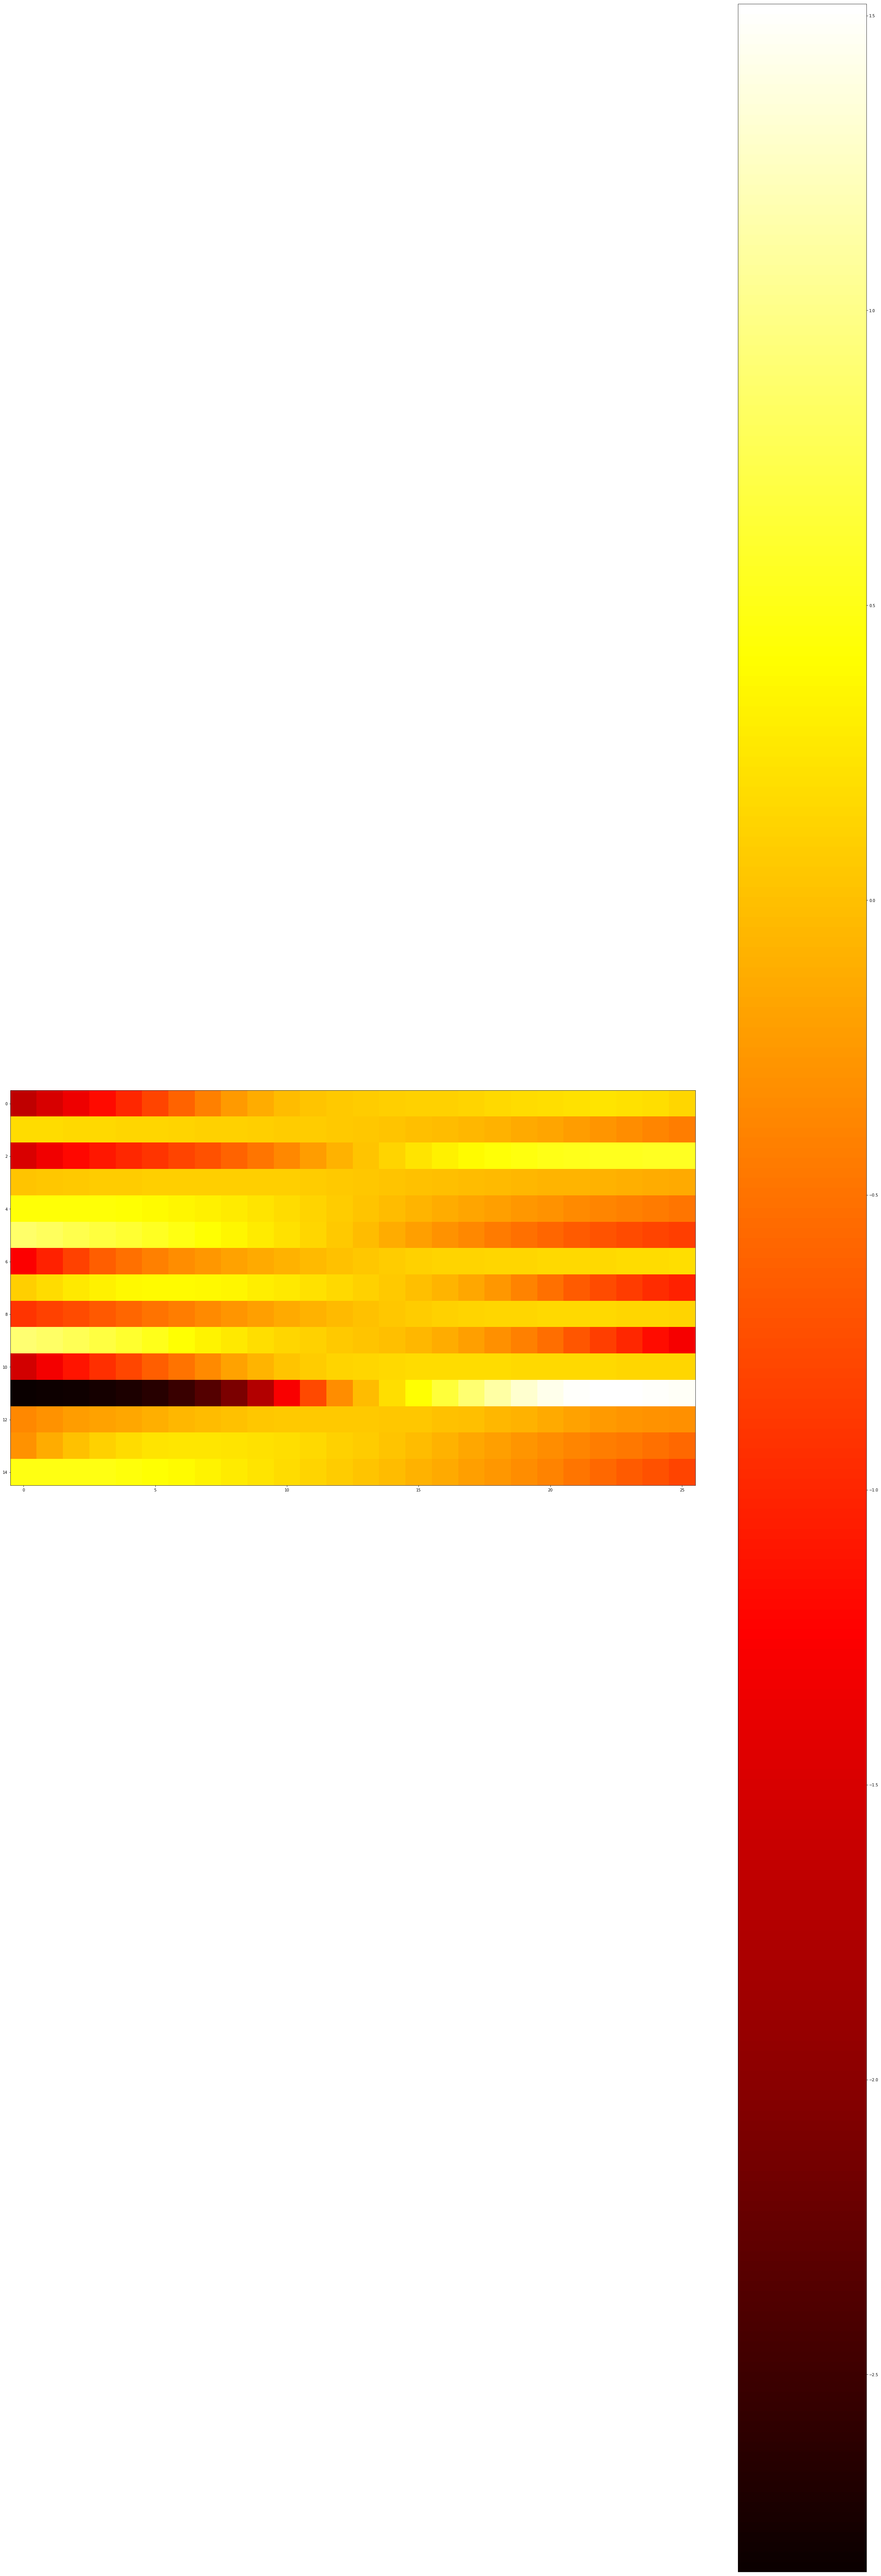

In [15]:
plt.figure(figsize=(40, 170))
plt.imshow(madminer_log_ratios, cmap='hot', interpolation='nearest')
plt.colorbar()


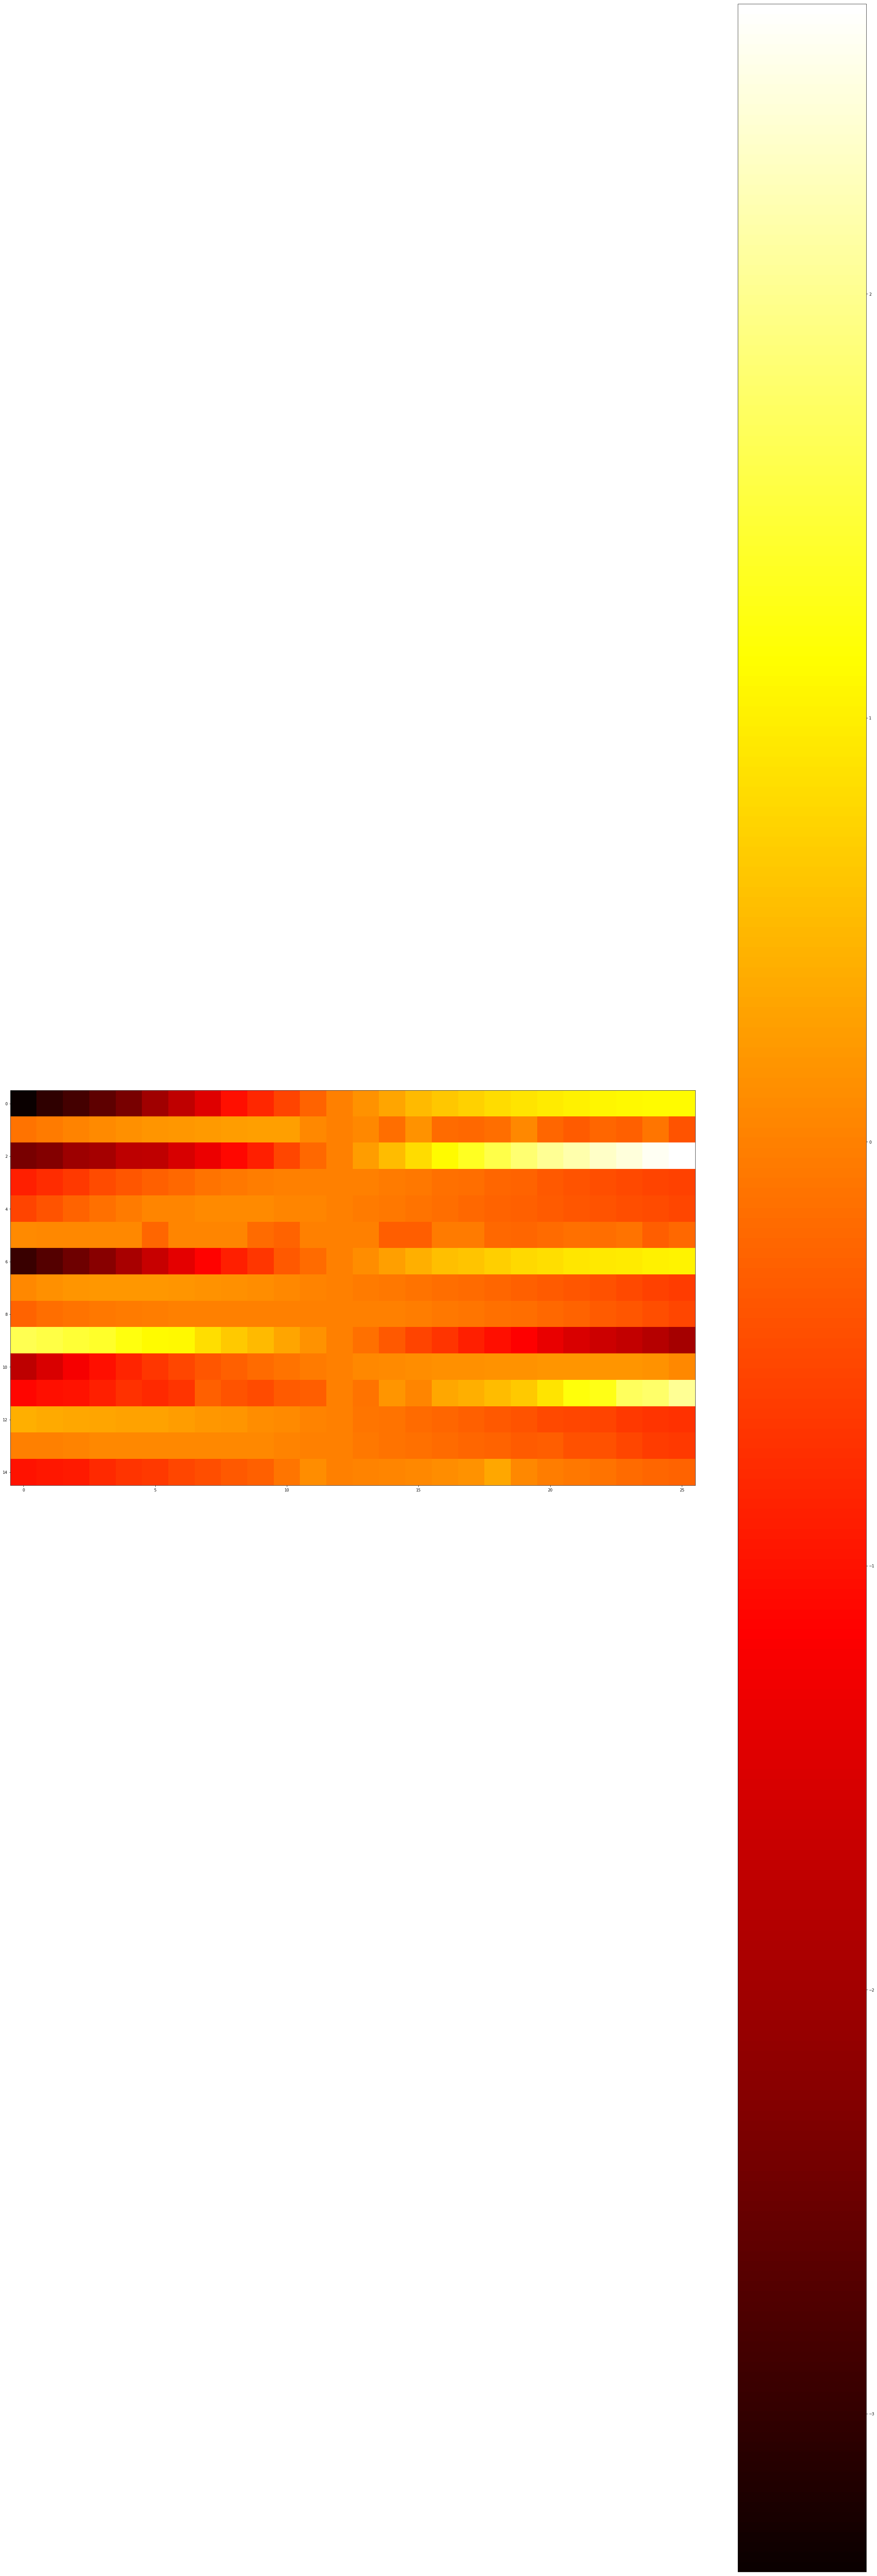

In [16]:
plt.figure(figsize=(40, 170))
plt.imshow(momemta_log_ratios, cmap='hot', interpolation='nearest')
plt.colorbar()